# Walkthrough of PSF characterization

For ALMA-IMF, we want to characterize the PSF shapes and the recovered beam sizes.

We showed the beams and a few features of the PSFs, but they were only described tersely in the paper.  This document goes through what we did in a little more detail

## Front matter (imports)

In [1]:
%matplotlib inline
import pylab as pl

# for display within notebook
pl.rcParams['figure.facecolor'] = 'w'

from spectral_cube import SpectralCube
from astropy import units as u

# Debuggy loading: this approach needed b/c the code isn't properly packaged
import imp
import sys
sys.path.append('/orange/adamginsburg/ALMA_IMF/reduction/analysis')
import imstats
imp.reload(imstats)
from imstats import get_psf_secondpeak

## N2H+

I chose to do this only for an N$_2$H+ example; the N$_2$H+ line cubes seem to have the worst-behaved beams in our samples.

In [2]:
basename = '/orange/adamginsburg/ALMAIMF_Images/G327.29/B3/linecubes_12m/G327.29_B3_spw0_12M_n2hp'
img = SpectralCube.read(f'{basename}.image')
psf = SpectralCube.read(f'{basename}.psf', format='casa_image')

The code `get_psf_secondpeak` does all of the work, we're just going to talk about what gets plotted.

INFO: first_sidelobe_ind=44, first_min_ind = 43 [imstats]


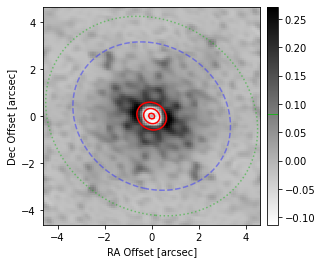

In [3]:
psffn = f'{basename}.psf'
(psf_secondpeak, psf_secondpeak_loc, psf_sidelobe1_fraction, epsilon, firstnull, r_sidelobe,
 (rr, pixscale, cutout, beam, fullbeam, view, bmfit_residual)) = \
        get_psf_secondpeak(psffn, show_image=True, min_radial_extent=2.5*u.arcsec,
                   max_radial_extent=5*u.arcsec,
                           specslice=slice(50,51),
                  )

The plot is showing:

* in red contours, the 10th, 50th, and 90th percentile of the Gaussian synthesized beam
* in grayscale, the _residual_ of the dirty beam minus the synthesized beam
* in green dashed (faint, outermost ellipse), the location of the first sidelobe peak.  The first sidelobe is defined as the first peak outside of the first null.
* in blue dashed (inner ellipse), the location of the first null.  This may not be a true null: it is the first minimum of the radial profile

Next, we show the radial profile.  The radial profile is an _elliptical_ profile, which is why the elliptical synthesized beam has a single profile.  

The X-axis is calculated as:

$$ r = \left(C^2 (x \cos \theta + y \sin \theta)^2 + (x \sin \theta - y \cos \theta)^2\right)^{1/2} $$

where $C = \theta_{min} / \theta_{maj}$.  So the radial axis is scaled to the major axis of the beam; the true beam is smaller along one axis than shown in these plots.

Text(0, 0.5, 'Normalized PSF profile')

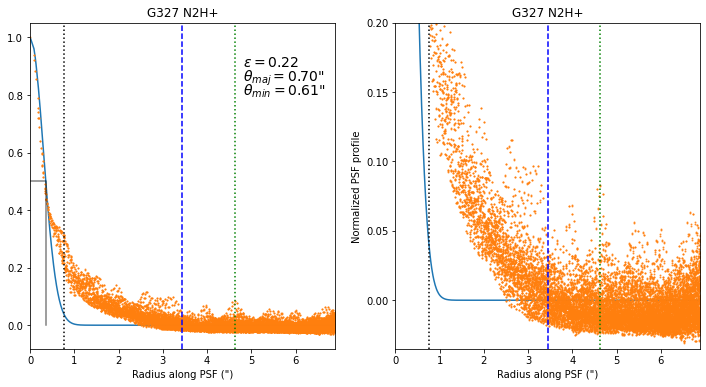

In [4]:
# radial profile
pl.figure(figsize=(12,6))
ax2=pl.subplot(1,2,1)
ax1=pl.subplot(1,2,2)


ax2.set_title('G327 N2H+')
rr_inds = rr.ravel().argsort()
sorted_synth = (fullbeam.array.ravel()/fullbeam.array.max())[rr_inds]
pixscale = pixscale.to(u.arcsec)
ax2.plot(pixscale.value*rr.ravel()[rr_inds], sorted_synth, '-', label='Synth')
ax2.plot(pixscale.value*rr.ravel(),
         cutout.value.ravel()/cutout.max().value, '.', label='Dirty', alpha=0.75, markersize=2)
ax2.axvline(firstnull.value, linestyle='--', color='b')
ax2.set_xlim(0, firstnull.value*2)# rr[view].max())
ax2.text(firstnull.value*1.4, 0.9, f'$\epsilon={epsilon:0.2f}$', fontsize=14)
ax2.text(firstnull.value*1.4, 0.85, f'$\\theta_{{maj}}={beam.major.value:0.2f}$"', fontsize=14)
ax2.text(firstnull.value*1.4, 0.8, f'$\\theta_{{min}}={beam.minor.value:0.2f}$"', fontsize=14)

ax2.axvline(psf_secondpeak_loc, linestyle=':', color='k')
ax2.axvline(r_sidelobe.value, linestyle=':', color='g')

ax2.plot([0, beam.major.value/2, beam.major.value/2],
         [0.5, 0.5, 0],
         color='k', alpha=0.5)


ax1.set_title('G327 N2H+')
ax1.plot(pixscale.value*rr.ravel()[rr_inds], sorted_synth, '-', label='Synth')
ax1.plot(pixscale.value*rr.ravel(),
         cutout.value.ravel()/cutout.max().value, '.', label='Dirty', alpha=0.75, markersize=2)
ax1.axvline(firstnull.value, linestyle='--', color='b')
ax1.axvline(psf_secondpeak_loc, linestyle=':', color='k')
ax1.axvline(r_sidelobe.value, linestyle=':', color='g')

ax1.set_xlim(0, firstnull.value*2)# rr[view].max())
ax1.set_ylim(-0.035, 0.2)

ax1.set_xlabel("Radius along PSF (\")")
ax2.set_xlabel("Radius along PSF (\")")
ax1.set_ylabel("Normalized PSF profile")

The right plot is a vertical zoom-in of the left plot.

The light blue line shows the synthesized beam.

The orange dots are the individual pixel values from the dirty beam.

The vertical dotted black line shows the peak of the residual - it's not used for anything, it just highlights where the "shelf" is most prominent (and it is _very_ prominent in this example).

The blue vertical dashed line shows the location of the first null.

The green vertical dotted line shows the location of the first sidelobe.

$\epsilon$ is the ratio of the integral of the synthesized beam to the integral of the dirty beam out to the first null.
It is the correction factor to apply to the residuals (multiply the residuals by this number) to convert the residuals from Jy/dirtybeam to Jy/synthesizedbeam.


$\theta_{min}$ and $\theta_{maj}$ are the FWHM widths of the beam along the major and minor axes.  The grey right-angle line is drawn at $y=0.5$ out to $\theta = \theta_{maj}/2$ (the half-width half-max)